
# Load the Data

### Lets import the Python libraries first and then the file through pandas to get a list of all the lines of text messages:


In [16]:
#Importing Libraries

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

#from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [18]:
# Reading the dataset and storing it in variable as dataframe
messages = pd.read_table('SMSSpamCollection',header = None,encoding = 'latin-1')
messages.head()

,0,1,2,3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN


# DATA CLEANING

In [19]:
#Show the number of missing values in each coulmn
messages.isnull().sum()

0       0
1       0
2    5522
3    5560
dtype: int64

In [24]:
#Remove the unnecessary columns or missing value column in dataset and rename the column names.
messages = messages.drop(labels = [2,3], axis = 1)
# Renaming the column 0 as label and column 1 as message
messages.columns = ["label", "message"]
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploring the dataset 

In [25]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [26]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [27]:
# we used groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [31]:
# Creating a new column for length of messages
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [32]:
# Count the frequency of top 5 messages.
messages['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,"Wen ur lovable bcums angry wid u, dnt take it ...",4
4,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4


# Visualizations

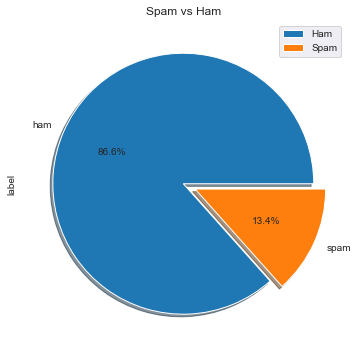

In [33]:
#Piechart to show the percentage of ham nd spam in the dataset
messages["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

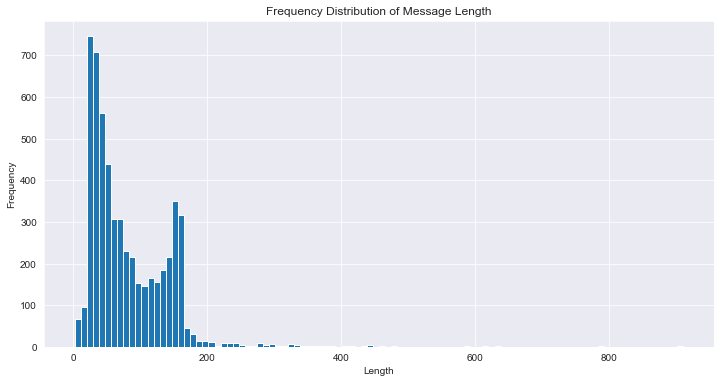

In [34]:
# Bar chart for Frequency Distribution of Message Length
plt.figure(figsize=(12,6))
messages['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [35]:
# info about the length column
messages['length'].describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [36]:
# displaying the first message having the length 910
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000208D8528E50>,
      dtype=object)

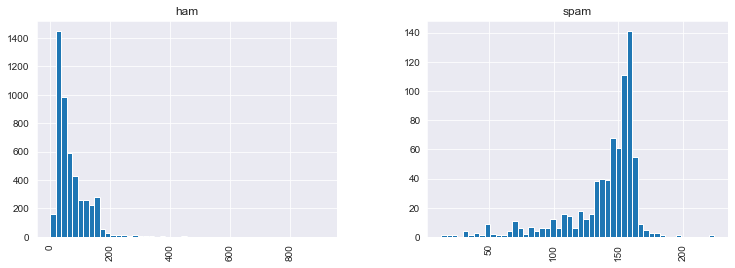

In [37]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

# DATA CLEANING

In [43]:
#check number of rows and column
messages.shape

(5572, 3)

In [44]:
#There are total 5572 SMS in this dataset with 3 columns present in dataset - label, messages and length.
#Remove duplicate records if available
messages.drop_duplicates(inplace=True)

In [45]:
print("After removing duplicate values rows and column present in dataset:")
messages.shape

After removing duplicate values rows and column present in dataset:


(5169, 3)

In [46]:
# Removing punctuation marks and stopwords from the messages
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    return nostop

In [47]:
# Separating spam messages and ham messages
spam_messages = messages[messages["label"] == "spam"]["message"]
ham_messages = messages[messages["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  653
No of ham messages :  4516


In [84]:
# creating a list of words from spam messages
spam_words = text_preprocess(spam_messages)
# lets print some spam words
spam_words[:10]

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may']

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may']

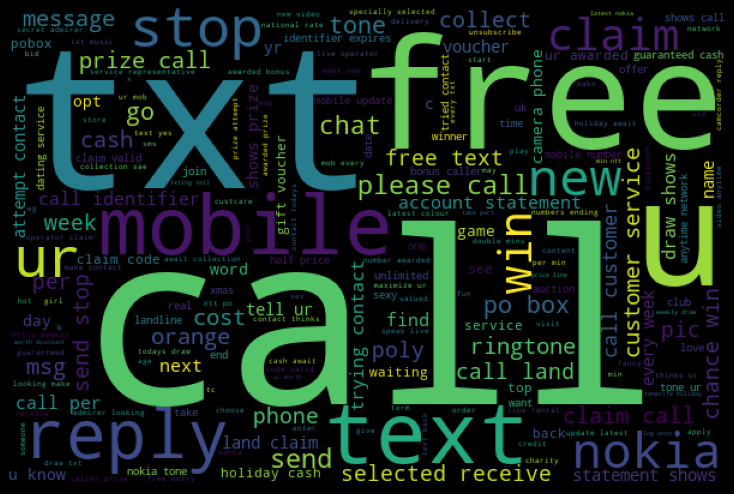

In [24]:
# Creating a wordcloud for spam words
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [50]:
print("Top 10 Spam words are :\n")
print(pd.Series(spam_words).value_counts().head(10))

Top 10 Spam words are :

call      288
free      131
txt       114
ur        105
mobile     94
text       92
reply      90
claim      88
u          82
stop       74
dtype: int64


In [51]:
# creating a list of words from ham messages
ham_words = text_preprocess(ham_messages)

In [52]:
# lets pring some ham words
ham_words[:10]

['go',
 'jurong',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'cine']

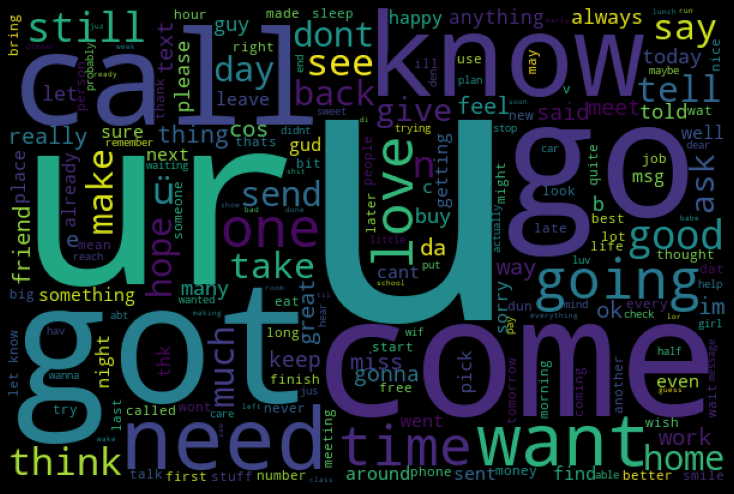

In [28]:
# Creating a wordcloud for ham words
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [53]:
# top 10 ham words based on their count
print("Top 10 Ham words are :\n")
print(pd.Series(ham_words).value_counts().head(10))

Top 10 Ham words are :

u        748
get      279
go       226
got      211
like     208
ur       200
know     192
come     188
call     161
going    146
dtype: int64


In [54]:
# Lets remove punctuations/ stopwords from all SMS 
messages["message"] = messages["message"].apply(text_preprocess)

In [55]:
# Conver the SMS into string from list
messages["message"] = messages["message"].agg(lambda x: ' '.join(map(str, x)))

In [56]:
messages.head()

,label,message,length
0,ham,go jurong point crazy available bugis n great ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry wkly comp win fa cup final tkts may...,155
3,ham,u dun say early hor u c already say,49
4,ham,nah dont think goes usf lives around though,61


# Bag of words 

#### The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity

In [57]:
# Creating the Bag of Words
# Note the here we are passing already process messages (after removing punctuations and stopwords)

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages['message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names()[20:40])
print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))

20 Bag of Words (BOW) Features: 

['absence', 'absolutely', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abusers', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation']

Total number of vocab words :  8129


In [58]:
message4 = messages['message'][27]
print(message4)

catch bus frying egg make tea eating moms left dinner feel love


In [59]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 921)	1
  (0, 1053)	1
  (0, 1803)	1
  (0, 2021)	1
  (0, 2047)	1
  (0, 2339)	1
  (0, 2600)	1
  (0, 3851)	1
  (0, 4037)	1
  (0, 4139)	1
  (0, 4421)	1
  (0, 6918)	1
(1, 8129)


In [60]:
print(bow_transformer.get_feature_names()[945])

cabin


In [61]:
# creating bag of words for all messages 
messages_bow = bow_transformer.transform(messages['message'])

In [62]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5169, 8129)
Amount of Non-Zero occurences:  40779


# TFIDF

#### TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [63]:
# Transforming the bag of words into tfidf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [64]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 6918)	0.32616311492146094
  (0, 4421)	0.31086547817716303
  (0, 4139)	0.21476239199609315
  (0, 4037)	0.19248982496467468
  (0, 3851)	0.2609784343305963
  (0, 2600)	0.3625033600177096
  (0, 2339)	0.2377495570877412
  (0, 2047)	0.3501647982067345
  (0, 2021)	0.32043601024802176
  (0, 1803)	0.2559267699938339
  (0, 1053)	0.31086547817716303
  (0, 921)	0.2652004872125561


In [65]:
print(bow_transformer.get_feature_names()[5945])
print(bow_transformer.get_feature_names()[3141])

samus
hoo


In [66]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['samantha']])

8.85748078694253


In [67]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5169, 8129)


In [68]:
messages["message"][:10]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts may...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
5    freemsg hey darling weeks word back id like fu...
6       even brother like speak treat like aids patent
7    per request melle melle oru minnaminunginte nu...
8    winner valued network customer selected receiv...
9    mobile months u r entitled update latest colou...
Name: message, dtype: object

In [47]:
# extracting the features from tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["message"])
print(features.shape)

print(len(vec.vocabulary_))

(5572, 7976)
7976


In [69]:
# Creating thaining and testing data
msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, messages['label'], test_size=0.2)

In [70]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4135, 8129)
train dataset label size (4135,)


test dataset features size (1034, 8129)
test dataset lable size (1034,)


# Naive Bayes Model

#### In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features (see Bayes classifier). They are among the simplest Bayesian network models,[1] but coupled with kernel density estimation, they can achieve higher accuracy levels.


In [71]:
# Training the model 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
spam_detect_model = clf.fit(msg_train, label_train)

In [72]:
predict_train = spam_detect_model.predict(msg_train)

In [73]:
# printing Precision, recall and f1score for train data
# Printing the confusion matrix 

print("Classification Report \n",metrics.classification_report(label_train, predict_train))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, predict_train))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train)))



Classification Report 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      3599
        spam       1.00      0.77      0.87       536

    accuracy                           0.97      4135
   macro avg       0.98      0.88      0.93      4135
weighted avg       0.97      0.97      0.97      4135



Confusion Matrix 
 [[3599    0]
 [ 124  412]]


Accuracy of Train dataset : 0.970


In [80]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages['label'][3])

predicted: ham
expected: ham


# MODEL EVALUATION

In [81]:
# Testing the model on test data
label_predictions = spam_detect_model.predict(msg_test)
print(label_predictions)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


In [82]:
# printing the precision, recall and f1score for test data
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       917
        spam       1.00      0.68      0.81       117

    accuracy                           0.96      1034
   macro avg       0.98      0.84      0.89      1034
weighted avg       0.96      0.96      0.96      1034

[[917   0]
 [ 38  79]]


In [83]:
# Printing the Overall Accuracy of the model
print("Accuracy of the model : {0:0.3f}".format(metrics.accuracy_score(label_test, label_predictions)))

Accuracy of the model : 0.963
